In [1]:
import platform
import sys
import os
import os.path as osp
import re
import datetime
from collections import namedtuple
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, jaccard_score

import logging
from logging.handlers import RotatingFileHandler
import traceback

logger = logging.getLogger("Rotating Log")
logger.setLevel(logging.ERROR)
handler = RotatingFileHandler("log.txt", maxBytes=20000, backupCount=5)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

print(platform.python_version())
print(sys.version)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.python.platform import tf_logging
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from keras import backend as K
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras_radam import RAdam
from keras.layers.advanced_activations import ReLU
from keras_contrib.layers.advanced_activations.swish import Swish
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical, plot_model
from keras.utils.vis_utils import model_to_dot
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from tqdm import tqdm, tqdm_notebook
import talos as ta
from talos.model.early_stopper import early_stopper
#from keras_tqdm import TQDMNotebookCallback

###################################
#Clean session
sess = get_session()
clear_session()
sess.close()
# TensorFlow wizardry
config = tf.ConfigProto(log_device_placement=True)

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################

# Magic used by the notebook to show figures inline

%matplotlib inline
# matplotlib default values
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "jet"

# auto-reloading packages
%load_ext autoreload
%autoreload 2

# local package
from mmciad.utils.io import create_samples, load_slides, load_slides_as_dict
from mmciad.utils.generator import DataGenerator
from mmciad.utils.u_net import u_net
from mmciad.utils.u_resnet import u_resnet
from mmciad.utils.custom_loss import (weighted_loss,
                                      jaccard2_loss,
                                      tversky_loss,
                                      categorical_focal_loss,
                                      get_weighted_categorical_crossentropy,
                                      tversky_ce,
                                      jaccard1_coef,
                                      generalised_wasserstein_dice_loss)
from mmciad.utils.preprocessing import calculate_stats, augmentor, calculate_class_weights, class_ratio, merge_labels
from mmciad.utils.callbacks import PatchedModelCheckpoint, DeadReluDetector
from mmciad.utils.metricsfinder import MetricsFinder

3.6.8
3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


Using TensorFlow backend.


In [2]:
from skimage.io import imread, imsave
from glob import glob

class_map = {
    "Background": 0,
    "Other": 1,
    "Epithelium": 2,
    "Glandular tissue": 3,
    "Necrosis": 4,
    "Stroma": 5,
    "Muscular tissue": 6,
    "Inflammation_lymphatic tissue": 7,
    "Ulcer": 8,
    "Dysplasia": 9,
    "Keratin pearl": 10,
    "Cancer": 11,
    "IGNORE": 12,
    "Healthy": 13,
}

class_colors = {
    0: [0, 0, 0],
    1: [128, 128, 128],
    2: [75, 195, 0],
    3: [0, 26, 128],
    4: [94, 243, 255],
    5: [255, 179, 128],
    6: [217, 30, 242],
    7: [204, 102, 51],
    8: [153, 51, 0],
    9: [245, 223, 37],
    10: [179, 230, 179],
    11: [179, 26, 26],
    12: [255, 255, 255],
    13: [0, 255, 0],
}
active_labels = [0, 1, 11, 12, 13]
active_classes = [sorted(class_map, key=class_map.get)[i] for i in active_labels]
print(active_classes)
colorvec = np.asarray([class_colors[i] for i in active_labels])
active_colors = {class_: class_colors[class_] for class_ in active_labels}
num_cls = len(active_labels)
print(colorvec.shape)
ignore_cls = 12

path = "./data/"
data_path = "./data/"
train_path = "rtrain/"
rval_path = "rval/"
val_path = "val/"
test_path = "rval/"
bg_class = class_map["Background"]
ignore_color = class_colors[12]
Size = namedtuple("Size", ["x", "y"])
np.random.seed(1992)

['Background', 'Other', 'Cancer', 'IGNORE', 'Healthy']
(5, 3)


In [3]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[1] - windowSize[0] + stepSize, stepSize):
        for x in range(0, image.shape[0] - windowSize[1] + stepSize, stepSize):
            # yield the current window
            res_img = image[x : x + windowSize[0], y : y + windowSize[1]]
            change = False
            if res_img.shape[1] != windowSize[1]:
                y = image.shape[1] - windowSize[1]
                change = True
            if res_img.shape[0] != windowSize[0]:
                x = image.shape[0] - windowSize[0]
                change = True
            if change:
                res_img = image[x : x + windowSize[0], y : y + windowSize[1]]
            yield (x, y, x + windowSize[0], y + windowSize[1], res_img)


def predict_window(model, img, step_size=1000, wsize=1024):
    size = Size(img.shape[0], img.shape[1])
    dtype = img.dtype
    num_class = model.layers[-1].output.shape[-1]
    if (size.x > wsize) & (size.y > wsize):
        output_img = np.zeros(shape=(size.x, size.y, num_class))
        output_img[:] = np.nan
        for (x, y, dx, dy, I) in sliding_window(img, step_size, (wsize, wsize)):
            window_prediction = model.predict(np.expand_dims(I, axis=0))
            try:
                output_img[x:dx, y:dy] = np.nanmean(
                    np.stack((output_img[x:dx, y:dy], np.squeeze(window_prediction)), axis=0), axis=0
                ).astype(dtype)
            except ValueError:
                print(dx-x, dy-y,'\n', window_prediction.shape)
                break
        return output_img
    output_img = model.predict(img)
    return output_img

def evaluate_window(model, slide, target, stepSize=1000, wsize=1024, batch_size=None, num_cls=11):
    X, Y, _ = slide.shape
    if (X > wsize) & (Y > wsize):
        input_tiles = []
        target_tiles = []
        for (x, y, dx, dy, I) in sliding_window(slide, wsize, (wsize, wsize)):
            input_tiles.append(I)
            target_tiles.append(target[x:dx,y:dy])
        input_tiles = np.asarray(input_tiles)
        target_tiles = np.asarray(target_tiles)
        if batch_size is None:
            batch_size = input_tiles.shape[0]
        return model.evaluate(x=input_tiles, y=target_tiles, batch_size=batch_size)
    else:
        return model.evaluate(x=slide, y=target, batch_size=1)


def concat_windows(slides, targets, stepSize=1000, wsize=1024):
    input_tiles = []
    target_tiles = []
    for slide, target in zip(slides, targets):
        X, Y, _ = slide.shape
        if (X > wsize) & (Y > wsize):
            for (x, y, dx, dy, I) in sliding_window(slide, wsize, (wsize, wsize)):
                input_tiles.append(I)
                target_tiles.append(target[x:dx,y:dy])
    input_tiles = np.asarray(input_tiles)
    target_tiles = np.asarray(target_tiles)
    return input_tiles, target_tiles

def find_contrast_min_and_max(img):
    AUTO_THRESHOLD = 5000
    pixcount = img.size
    limit = pixcount/10
    threshold = pixcount/AUTO_THRESHOLD
    n_bins = 256
    values, histogram = np.histogram(img, n_bins)
    i = 0 # start at zero rather than -1 to avoid accounting for empty patches
    found = False
    count = 0
    while True:
        i += 1
        count = values[i]
        if count>limit:
            count = 0
        found = count> threshold
        if found or i>=255:
            break
    hmin = i
    found = False
    i = 256
    while True:
        i -= 1
        count = values[i]
        if count>limit:
            count = 0
        found = count> threshold
        if found or i<1:
            break
    hmax = i
    return hmin/256, hmax/256

def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

lag = 10
threshold = 2
influence = 0

def auto_contrast(img, order=['b','r','g']):
    from skimage import exposure
    from scipy import stats
    output_img = np.zeros_like(np.squeeze(img))
    CHANNEL_INDEX = {'r': 0, 'g': 1, 'b': 2}
    ch = ['red','green','blue']
    for i, c in enumerate([CHANNEL_INDEX[channel] for channel in order]):
        v_min, v_max = find_contrast_min_and_max(img[..., i])
        hist, bins_ = np.histogram(img[..., i], bins=256)
        t = thresholding_algo(hist, lag, threshold, influence)
        v_min = t["signals"].argmax()/256
        #midpoint = v_max - v_min
        #v_min = midpoint - 30/256.
        #print(ch[c], "(c: {})".format(c), order[i], "(i: {})".format(i))
        #print("before:",v_min, v_max)
        if c == 0:
            v_min = (t["signals"].argmax()+1)/256
            #v_max = np.percentile(img[..., i], (95.0))
        elif c == 1:
            v_min = t["signals"].argmax()/256
        elif c == 2:
            v_min = (t["signals"].argmax())/256
            #print(t["signals"])
            #v_min *= 1.3
            #v_min = max(v_min, np.percentile(img[..., i], (40.0)))
            #v_max = np.percentile(img[..., i], (98.0))
        #print("after:",v_min, v_max)
        output_img[..., c] = exposure.rescale_intensity(img[..., i], in_range=(v_min, v_max))
    return output_img

In [4]:
train_m, train_s, x_min, x_max = calculate_stats(path=data_path, local=False)

In [5]:
if True:
    test_slides, test_targets_reduced = load_slides_as_dict(path, "test", train_m, train_s, [x_min, x_max], "gt", 5, colorvec)
    active_labels = [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12]
    colorvec = np.asarray([class_colors[i] for i in active_labels])
    _, test_targets_full = load_slides_as_dict(path, "test", train_m, train_s, [x_min, x_max], "gt-full", 11, colorvec)
#raw_test_slides = load_slides_as_dict(path, "test", load_gt=False)
remap_pattern = {0: [0, ], 1: [1,10], 2: [2,], 3: [3,], 4: [4,], 5: [5,], 6: [6,], 7: [7,], 8: [8,], 9: [9,]}
bin_class = len(remap_pattern)
print(bin_class)
old_test_targets = {name: to_categorical(merge_labels(np.argmax(img, axis=-1), remap_pattern), num_classes=bin_class) for name, img in test_targets_full.items()}

10


In [6]:
def my_weighted_loss(original_loss_func, weights_list):
    def loss_func(y_true, y_pred):
        axis = -1  # if channels last
        # axis=  1 #if channels first

        # argmax returns the index of the element with the greatest value
        # done in the class axis, it returns the class index
        class_selectors = K.argmax(y_true, axis=axis)

        # considering weights are ordered by class, for each class
        # true(1) if the class index is equal to the weight index
        class_selectors = [
            K.equal(K.cast(i, "int64"), K.cast(class_selectors, "int64"))
            for i in range(len(weights_list))
        ]

        # casting boolean to float for calculations
        # each tensor in the list contains 1 for ground true class is equal to its index
        # if you sum all these, you will get a tensor full of ones.
        class_selectors = [K.cast(x, K.floatx()) for x in class_selectors]

        # for each of the selections above, multiply their respective weight
        weights = [
            sel * w
            for sel, w in zip(
                class_selectors, sorted(value for value in weights_list.values())
            )
        ]

        # sums all the selections
        # result is a tensor with the respective weight for each element in predictions
        weight_multiplier = weights[0]
        for i in range(1, len(weights)):
            weight_multiplier = weight_multiplier + weights[i]

        # make sure your original_loss_func only collapses the class axis
        # you need the other axes intact to multiply the weights tensor
        loss = original_loss_func(y_true, y_pred)
        loss = loss * weight_multiplier

        return loss

    return loss_func

def get_weighted_categorical_crossentropy(weights):
    """L = - \sum_i weights[i] y_true[i] \log(y_pred[i])
    :param weights: a list of weights for each class.
    :return: loss function.
    """
    
    wten = weights[:10]

    def w_cat_CE(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = (y_true * K.log(y_pred) * weights) if y_pred.shape[-1] == 11 else (y_true * K.log(y_pred) * wten)
        loss = -K.sum(loss, -1)
        return loss

    return w_cat_CE

In [32]:
import warnings
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


weight_path = "./models/"
results_path = "./results/"
out_path = "./output/"
train_date_pattern = "*"
loss_pattern = "*"
compile_date = "2020-01-24"
models = sorted(glob(osp.join(weight_path, train_date_pattern, "*", loss_pattern, "*.h5")), key=str.lower)
print(len(models))
#eval_kwargs = model_kwargs
#eval_kwargs["activation"] = Swish
#eval_kwargs["output_channels"] = num_cls
full_cls_wgts = {0: 0.6462842253714038, 1: 4.277279367175925, 2: 0.7650382887989682, 3: 2.3366233721836207,
                 5: 0.38495865467512297, 6: 11.749891543465838, 7: 0.7357313031667244,
                 9: 3.3815931126719256, 10: 107.61779250337312, 11: 0.5449941506459005, 12: 0}
cat_focal_loss = categorical_focal_loss()
w_cat_CE = get_weighted_categorical_crossentropy(list(full_cls_wgts.values()))
w_cat_CE.__name__ = 'w_cat_CE'
w_cat_FL = weighted_loss(categorical_focal_loss, full_cls_wgts)
w_cat_FL.__name__ = 'w_cat_FL'
w_TL = my_weighted_loss(tversky_loss, full_cls_wgts)
w_TL.__name__ = 'w_TL'
weighted_categorical_crossentropy = my_weighted_loss(categorical_crossentropy, full_cls_wgts)
weighted_categorical_crossentropy.__name__ = 'weighted_categorical_crossentropy'
custom_objects = {'Swish': Swish,
                  'RAdam': RAdam,
                  'tversky_loss': tversky_loss,
                  'tversky_ce': tversky_ce,
                  'jaccard1_coef': jaccard1_coef,
                  'jaccard2_loss': jaccard2_loss,
                  'categorical_focal_loss_fixed': cat_focal_loss,
                  'w_cat_CE': w_cat_CE,
                  'w_cat_FL': w_cat_FL,
                  'loss_func': w_cat_CE,
                  'w_TL': w_TL,
                  'weighted_categorical_crossentropy': weighted_categorical_crossentropy}

metrics_finder = MetricsFinder()

warnings.filterwarnings("once", message=r"Exception ignored in")
mylogger = logging.getLogger('tensorboard')
mylogger.setLevel(40)

if True:
    tb_logs = os.walk("./logs/", topdown=False)
    events = []
    for root, dirs, files in tb_logs:
        for name in files:
            efile = os.path.join(root, name)
            if name.startswith("events.out"):# and "2020-" in root:
                epath = os.path.split(efile)[:-1]
                s = EventAccumulator('/'.join(epath)).Reload()
                date, loss_fn = epath[0].split('/')[2:4]
                loss_fn = loss_fn.split(' ')[0]
                if re.search(r'((?<=init_)|(?<=initialization_))([a-zA-Z_]+)(?=-| |/)', efile) is not None:
                    init = re.search(r'((?<=init_)|(?<=initialization_))([a-zA-Z_]+)(?=-| |/)', efile).group()
                else:
                    init = "glorot_uniform"
                opt = False
                act = False
                nb_filters = False
                for i in s.Graph().node:
                    name = i.name.lower()
                    if "block1" in name and name.endswith("conv1/kernel"):
                        if nb_filters:
                            continue
                        nb_filters = i.attr['_output_shapes'].list.shape[0].dim[-1].size
                        #print(nb_filters)
                    if re.search(r"([R]*Adam)", i.name):
                        if opt:
                            continue
                        opt = re.search(r"([R]*Adam)", i.name).group()
                        #print(opt)
                    if "swish" in name:
                        if act:
                            continue
                        act = "Swish"
                        #print("act: ", act)
                    if "relu" in name:
                        if act:
                            continue
                        act = "ReLU"
                    #if "leaky_re_lu" in name:
                    #    print(i)
                    #    act = "leaky_ReLU"
                    actstring = (r"((?<=act_)|(?<=activation_)|(?<=act_[<a-zA-Z._]{35}))"
                                 + r"[a-zA-Z_]+((?= object at 0x[0-9abcdef]{12}>)|(?=-)|(?=/))")
                if re.search(actstring, efile):
                    act = re.search(actstring, efile).group()
                if not opt:
                    opt = "Adam"
                try:
                    lr = s.Scalars('lr')[0].value
                except KeyError as e:
                    #print(epath)
                    for j, i in enumerate(s.Graph().node):
                        if "adam/lr/initial_value" in re.sub("learning_rate","lr", i.name.lower()):
                            #print("node ", j)
                            #print(i.attr['value'].tensor.float_val[0])
                            lr = i.attr['value'].tensor.float_val[0]
                if not act:
                    print('/'.join(epath))
                    data.append('/'.join(epath))
                repl = {"categorical_crossentropy": "cat_CE",
                        "categorical_focal_loss_fixed": "cat_FL",
                        "weighted_categorical_crossentropy": "w_cat_CE"}
                for key, val in repl.items():
                    if loss_fn == key:
                        loss_fn = val
                data = [date, loss_fn, init, opt, act, nb_filters, lr]
                #print(efile)
                #print(data)
                events.append(data)

        for folder in dirs:
            pass

if True:
    for idx, modelpath in enumerate(models):
        slide_list = []
        target_list = []
        target_byte_list = []
        prediction_byte_list = []
        try:
            sess = get_session()
            clear_session()
            del model
            K.tensorflow_backend.set_session(tf.Session(config=config))
            print("[INFO]: Object 'model' sucessfully deleted")
        except NameError:
            print("[INFO]: Object 'model' does not exist")
        except RuntimeError:
            print("[INFO]: No session to end.")

        model = load_model(modelpath, custom_objects=custom_objects)
        print(f"Model {idx+1}/{len(models)} (path: {modelpath})")
        print(model.metrics_names)
        metrics_finder(model, modelpath)
        metrics_finder.get_lr(events, idx)
        nb_classes = model.layers[-1].output.shape[-1]
        cls_test = metrics_finder.metrics["nb_classes"][-1]
        assert cls_test == nb_classes, f"{cls_test} not equal to {nb_classes}"
        if nb_classes == 5:
            test_targets = test_targets_reduced
            active_labels = [0, 1, 11, 12, 13]
            assert nb_classes == len(active_labels), "label mismatch: nb_classes ({}) != active_labels ({})".format(nb_classes, len(active_labels))
            colorvec = np.asarray([class_colors[i] for i in active_labels])
        elif nb_classes == 10:
            test_targets = old_test_targets
            active_labels = [0, 1, 2, 3, 5, 6, 7, 9, 10, 11]
            assert nb_classes == len(active_labels), "label mismatch: nb_classes ({}) != active_labels ({})".format(nb_classes, len(active_labels))
            colorvec = np.asarray([class_colors[i] for i in active_labels])
        else:
            test_targets = test_targets_full
            active_labels = [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12]
            assert nb_classes == len(active_labels), "label mismatch: nb_classes ({}) != active_labels ({})".format(nb_classes, len(active_labels))
            colorvec = np.asarray([class_colors[i] for i in active_labels])
        for name, target in test_targets.items():
            slide = np.squeeze(test_slides[name])
            print(name, target.shape)
            print(evaluate_window(model, slide, target, stepSize=190, wsize=208, batch_size=12))
            slide_list.append(np.squeeze(test_slides[name]))
            target_list.append(target)
            output = predict_window(model, slide, step_size=190, wsize=208)
            prediction = colorvec[np.argmax(output, axis=-1)]
            train_date = str(osp.split(modelpath)[0]).split('/')[-3]
            loss_dir = str(osp.split(modelpath)[0]).split('/')[-2]
            arch_dir = str(osp.split(modelpath)[0]).split('/')[-1]
            base_name = osp.split(modelpath)[-1]
            class_wgt_dir = 'weights_{}'.format('True' in str(base_name))
            act_dir = '{}'.format(base_name[base_name.rfind('activation_'):base_name.find('-dropout_')])
            init_dir = '{}'.format(base_name[base_name.rfind('initialization_'):base_name.find('-activation_')])
            res_path = osp.join(
                out_path,
                compile_date,
                "test_inference",
                loss_dir,
                arch_dir,
                train_date+Path(modelpath).stem
            )
            if not osp.exists(res_path):
                os.makedirs(res_path)
            imsave(res_path + "/" + name + "_result_argmax.png", prediction.astype(np.uint8), check_contrast=False)
            target_byte = np.argmax(test_targets[name], axis=-1)
            target_byte_list.append(np.ndarray.flatten(target_byte))
            prediction_byte_list.append(np.ndarray.flatten(np.argmax(output, axis=-1)))
        y_true = np.hstack(target_byte_list)
        y_pred = np.hstack(prediction_byte_list)
        jaccard = jaccard_score(y_pred, y_true, average=None)
        avg_jaccard = jaccard_score(y_pred, y_true, average="micro")
        avg_ign_jaccard = jaccard_score(y_pred, y_true, average="micro")
        print(jaccard)
        print(avg_jaccard)
        input_tiles, target_tiles = concat_windows(slide_list, target_list, stepSize=190, wsize=208)
        test_metrics = model.evaluate(x=input_tiles, y=target_tiles, batch_size=12)
        if len(test_metrics) == 2:
            test_metrics.append(avg_jaccard)
        metrics_finder.append_scores(test_metrics)
        print(test_metrics,'\n')
        print('-'*120,'\n')

128
[INFO]: Object 'model' does not exist
Model 1/128 (path: ./models/2019-06-24/arch_BUnet/cat_CE Adam/arch_BUnet-bs_16-decay_0.0-drop_0-weights_False-pretrain_2-sigma_0.h5)
['loss', 'acc']
N4b (3787, 4061, 10)
380/380 [==============================] - 13s 34ms/step
[1.8448026100957864, 0.6430672340487179]
N5 (4164, 3378, 10)
357/357 [==============================] - 4s 12ms/step
[1.1149645539141502, 0.5973085748548267]
T4b-1 (2604, 6162, 10)
390/390 [==============================] - 5s 12ms/step
[1.9432562612283688, 0.6322308567854075]
[0.5962457  0.01893926 0.00966495 0.11218934 0.         0.
 0.        ]
0.4295539519611566
1127/1127 [==============================] - 12s 11ms/step
[1.6476817039182838, 0.6248223095894283, 0.4295539519611566] 

------------------------------------------------------------------------------------------------------------------------ 

[INFO]: Object 'model' sucessfully deleted
Model 2/128 (path: ./models/2019-06-24/arch_BUnet/cat_CE Adam/arch_BUnet-b

In [27]:
print(modelpath)

./models/2019-12-06/tversky_loss Adam/arch_BSUnet/reduced_classes-nb_filters_64-sigma_noise_0.01-depth_4-maxpool_False-initialization_he_normal-activation_Swish-dropout_0-output_channels_5-batchnorm_True.h5


In [ ]:
#print(modelpath)
index = 0
def get_lr(events):
    date = metrics_finder.metrics["date"][index]
    print(edf[(edf.date.str.contains(str(date)))])
get_lr(events)
metrics_finder.metrics["date"][index]

In [33]:
metrics_finder.export_to_csv(os.path.join(out_path,compile_date,"results.csv"))

In [ ]:
print(len(metrics_finder.metrics['init_lr']))
print(len(metrics_finder.metrics['date']))
metrics_finder.metrics['init_lr']

In [ ]:
t = EventAccumulator('logs/2019-06-24/cat_CE/act_ReLU-bs_16-nb_filters_64-decay_0.0-drop_0-weights_False-pretrain_2-sigma_0/').Reload()

In [ ]:
#print(t.Tags())
import time
for j, i in enumerate(t.Graph().node):
    name = i.name.lower()
    if "block1" in name and name.endswith("conv1/kernel"):
        print("node {}: {}".format(j, i.name))
        print(i.attr['T'])
        #print(i.attr['_output_shapes'].list.shape[0].dim[-1].size)
print()
opt = False
act = False
nb_filt = False
reverse = False
start = time.time()
for i in t.Graph().node:
    if "conv1/kernel" in i.name:
        if nb_filt:
            continue
        nb_filt = i.attr['_output_shapes'].list.shape[0].dim[-1].size
        #print("nb_filt: ", nb_filt)
    if "/lr/Assign" in i.name:
        if opt:
            continue
        opt = i.name.split('/')[0]
        #print("opt: ", opt)
    if "swish" in i.name.lower():
        if act:
            continue
        act = "Swish"
        #print("act: ", act)
    if "relu" in i.name.lower():
        if act:
            continue
        if "leaky" in i.name.lower():
            act = "leaky_ReLU"
        else:
            act = "ReLU"
        #print("act: ", act)
print(f"time: {time.time()-start}")
#t.Scalars('lr')[0].value
t.Tags()

In [ ]:
conv_name = None
for layer in model.layers:
    if re.search(r"conv[0-9]$", layer.name) and conv_name is None:
        print("true")
        conv_name = re.search(r"conv[0-9]$", layer.name).group()
    if conv_name is not None:
        if conv_name in layer.name:
            print(layer.name)
print(conv_name)
for layer in model.layers:
    if re.search(r"conv[0-9]$", layer.name):
        conv_name = layer.name
        nb_filters = layer.output.shape[-1].value
        continue
if "conv3" in conv_name:
    print(nb_filters//4)
else:
    print(nb_filters)

In [ ]:
tb_logs = os.walk("./logs/", topdown=False)
events = []
for root, dirs, files in tb_logs:
    for name in files:
        efile = os.path.join(root, name)
        if name.startswith("events.out"):
            epath = os.path.split(efile)[:-1]
            try:
                s = EventAccumulator('/'.join(epath)).Reload()
                date, loss_fn = epath[0].split('/')[2:4]
                opt = False
                act = False
                nb_filt = False
                for i in s.Graph().node:
                    if "conv1/kernel" in i.name:
                        if nb_filt:
                            continue
                        nb_filt = i.attr['_output_shapes'].list.shape[0].dim[-1].size
                        print("filters: ", nb_filt)
                    if "/lr/Assign" in i.name:
                        if opt:
                            continue
                        opt = i.name.split('/')[0]
                        print("opt: ", opt)
                    if "swish" in i.name.lower():
                        if act:
                            continue
                        act = "Swish"
                        print("act: ", act)
                    if "relu" in i.name.lower():
                        if act:
                            continue
                        if "leaky" in i.name.lower():
                            act = "leaky_ReLU"
                        else:
                            act = "ReLU"
                        print("act: ", act)
                if not opt:
                    opt = "Adam"
                lr = s.Scalars('lr')[0].value
                data = [date, loss_fn, opt, act, nb_filters, lr]
                print(data)
                if not act or not opt or not nb_filt:
                    print('/'.join(epath))
                    data.append('/'.join(epath))
                if not nb_filt:
                    raise ValueError("Missing value for nb_filt")
                events.append(data)
            except KeyError:
                print(epath)
            
    for folder in dirs:
        pass

In [ ]:
import pprint
print(len(events))
edf = pd.DataFrame(events, columns=['date', 'loss_func', "init", 'opt','act','nb_filters0','lr']).drop_duplicates()
#print(edf)
key_filter = ["init_lr", "best_loss", "best_acc", "best_jaccard"]

hit = {
    key: "cat_CE" if val[-1] == "categorical_crossentropy" else val[-1]
    for key, val in metrics_finder.metrics.items()
    if key not in key_filter
}
#hit['act_func'] = 'ReLU'
print(edf[edf.date.str.contains(hit['date'])])
pprint.pprint(hit)
pprint.pprint(metrics_finder.metrics)
#print(edf[edf.date.str.contains(hit['date']) & (edf.act == hit['act_func']) & (edf.init == hit['kernel_init']) & (edf.nb_filters0 == hit['nb_filters0'])])
#print(edf[edf.date.str.contains('2019-07-16') & (edf.act == "ReLU") & (edf.nb_filters0 == 32)].lr.get_values()[0])
# ./models/2019-06-26/arch_BUnet/cat_FL Adam/arch_BUnet-bs_16-decay_0.0-drop_0-weights_False-pretrain_2-sigma_0.h5
#pd.Series.get_value

In [40]:
#metrics_finder.metrics_df#['init_lr'] = metrics_finder.metrics_df['init_lr'].fillna(value=9.999999747378752e-05)
import pandas as pd
df = pd.read_csv('output/2020-01-20/results.csv')
df.date = pd.to_datetime(df.date)
df.loss_func = df.loss_func.astype('category')
df.act_func = df.act_func.astype('category')
df.opt_func = df.opt_func.astype('category')
df.kernel_init = df.kernel_init.astype('category')
df.info()
df['loss_func_e'] = df.loss_func.cat.codes
df['act_func_e'] = df.act_func.cat.codes
df['opt_func_e'] = df.opt_func.cat.codes
df['kernel_init_e'] = df.kernel_init.cat.codes
df['act_func'].cat.categories.tolist()
#df.to_csv('backup.csv')
#pd.plotting.parallel_coordinates(df[['date','loss_func_e','act_func_e','opt_func_e', 'batch_size', 'nb_filters0', 'nb_classes', 'init_lr', 'kernel_init_e', 'pretrained_layers', 'sigma_noise', 'best_acc', 'best_jaccard']], 'date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 20 columns):
Unnamed: 0           128 non-null int64
date                 128 non-null datetime64[ns]
model                128 non-null object
train_params         128 non-null int64
nontrain_params      128 non-null int64
loss_func            128 non-null category
act_func             128 non-null category
opt_func             128 non-null category
depth                128 non-null int64
batch_size           128 non-null int64
nb_filters0          128 non-null int64
nb_classes           128 non-null int64
init_lr              128 non-null float64
kernel_init          128 non-null category
class_weights        128 non-null bool
pretrained_layers    128 non-null object
sigma_noise          128 non-null float64
best_loss            128 non-null float64
best_acc             128 non-null float64
best_jaccard         128 non-null float64
dtypes: bool(1), category(4), datetime64[ns](1), float64(5), in

['LeakyReLU', 'ReLU', 'Swish']

In [35]:

import plotly.express as px
import plotly.graph_objects as go

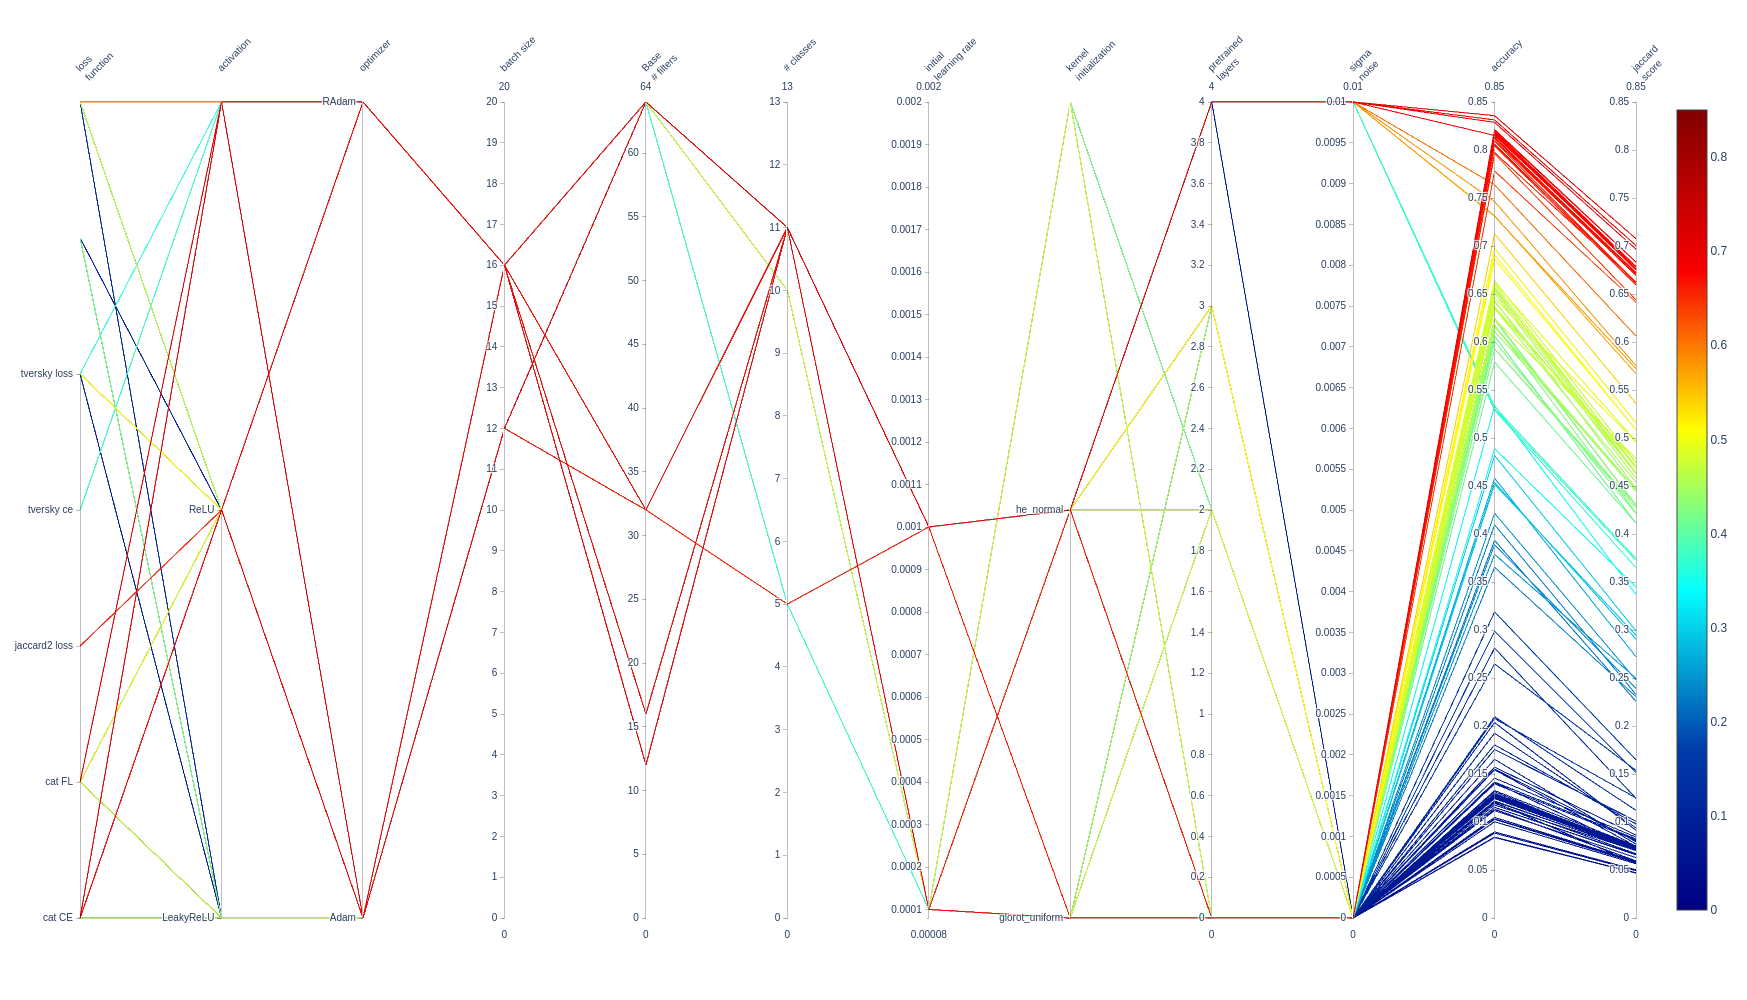

In [42]:
plt.rcParams["figure.figsize"] = (18.0, 20.0)
fig = go.Figure(
    data=go.Parcoords(
        line = dict(
            color = df['best_jaccard'],
            colorscale = 'jet',
            showscale = True,
            cmin = 0,
            cmax = 0.85
        ),
        labelangle = -45,
        dimensions = [
            #'date',
            {'tickvals': [0,1,2,3,4],
            'label': 'loss<br>function',
            'values': df['loss_func_e'],
            'ticktext': df['loss_func'].cat.categories.str.replace('_',' '),
            'tickformat': '%c'
            },
            {'tickvals': [0,1],
            'label': 'activation',
            'values': df['act_func_e'],
            'ticktext': df['act_func'].cat.categories.tolist()
            },
            {'tickvals': [0,1],
             'label': 'optimizer',
             'values': df['opt_func_e'],
             'ticktext': df['opt_func'].cat.categories.tolist()
            }, 
            {'label': 'batch size',
             'range': [0, 20],
             'values': df['batch_size']
            },
            {'label': 'Base<br># filters',
             'range': [0,64],
             'values': df['nb_filters0']
            },
            {'label': '# classes',
             'range': [0,13],
             'values': df['nb_classes']
            },
            {'label': 'initial<br>learning rate',
             'range': [0.00008, 0.002],
             'values': df['init_lr']
            },
            {'label': 'kernel<br>initialization',
             'tickvals': [0,1],
             'values': df['kernel_init_e'],
             'ticktext': df['kernel_init'].cat.categories.tolist()
            },
            {'label': 'pretrained<br>layers',
             'range': [0,4],
             'values': df['pretrained_layers']
            },
            {'label': 'sigma<br>noise',
             'range': [0, 0.01],
             'values': df['sigma_noise']
            },
            {'label': 'accuracy',
             'range': [0.0, 0.85],
             'values': df['best_acc']
            },
            {'label': 'jaccard<br>score',
             'range': [0,0.85],
             'values': df['best_jaccard']
            }
        ]
    )
)
fig.update_layout(
    height=1000
)
fig.show()


In [44]:
import subprocess
import plotly.io as pio
subprocess.Popen(
    [
        '/usr/bin/orca',
        'serve',
        '-p',
        '44664',
        '--plotly',
        '/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/plotly/package_data/plotly.min.js',
        '--graph-only',
        '--mathjax',
        'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js',
        '--keep-alive'
    ],
    stdout=subprocess.PIPE,
    shell=True
)
pio.orca.config.timeout = 500
pio.orca.status

orca status
-----------
    state: unvalidated
    executable: None
    version: None
    port: None
    pid: None
    command: None


In [45]:
fig.write_image("output/parcoords.png")

ValueError: 
For some reason plotly.py was unable to communicate with the
local orca server process, even though the server process seems to be running.

Please review the process and connection information below:

orca status
-----------
    state: running
    executable: /usr/bin/orca
    version: 1.2.1
    port: 43206
    pid: 35281
    command: ['/usr/bin/orca', 'serve', '-p', '43206', '--plotly', '/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/plotly/package_data/plotly.min.js', '--graph-only', '--mathjax', 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js']




In [ ]:
df.date = pd.to_datetime(df.date)
df.loss_func = df.loss_func.astype('category')
df.act_func = df.act_func.astype('category')
df.opt_func = df.opt_func.astype('category')
df.kernel_init = df.kernel_init.astype('category')
df.info()

In [46]:
pio.write_json(fig, "figure.json", pretty=True)